# EDA + Otuna Ensemble (lgb, xgb, cat)

In [1]:
# https://www.kaggle.com/code/shadechen/eda-otuna-ensemble-lgb-xgb-cat
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sub = pd.read_csv('./data/sample_submission.csv')
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [3]:
# 結果に変更が加えられないため、id 列を削除します。
train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

In [4]:
# NAがあるかどうかを確認する
train.isna().sum().any(),  test.isna().sum().any()

(False, False)

In [5]:
# 重複をチェックする
total = pd.concat([train.drop('Status', axis=1), test], axis = 0)
total.duplicated().sum()

0

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status  

In [7]:
# 各列の一意の値の数を確認します
train[train.columns].nunique().sort_values(ascending=True)

Drug               2
Sex                2
Ascites            2
Hepatomegaly       2
Spiders            2
Status             3
Edema              3
Stage              4
Prothrombin       49
Bilirubin        111
Tryglicerides    154
Albumin          160
Copper           171
SGOT             206
Cholesterol      226
Platelets        227
Alk_Phos         364
Age              391
N_Days           461
dtype: int64

In [8]:
# 浮腫には3つの価値があります、見てみましょう
train.Edema.value_counts()
# N: いいえ
# Y: はい
# S: わずかに

N    7161
S     399
Y     345
Name: Edema, dtype: int64

In [9]:
# 薬物コラムを見てみましょう
train.Drug.value_counts()

Placebo            4010
D-penicillamine    3895
Name: Drug, dtype: int64

In [10]:
# 対象のデータを確認する
train.Status.value_counts()

C     4965
D     2665
CL     275
Name: Status, dtype: int64

基本的な洞察:

    データセットに欠損値はありません。
    データセットには重複する値はありません。
    ターゲットの「ステータス」には 3 つの一意の値 (C、CL、D) が含まれており、ラベルエンコードするか、さらなる予測のためにワンホット エンコードを適用する必要があります。
    バイナリ特徴または True または False などのカテゴリ特徴を変換する必要があるため、ラベル エンコーディングまたはワンホット エンコーディングの適用を検討してください。

# EDA(探索的データ解析)

In [11]:
# 数値データを取得する
num_train = train.select_dtypes(include = ['int', 'float'])
num_train.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0
2,3428,13727,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0
3,2576,18460,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0
4,788,16658,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0


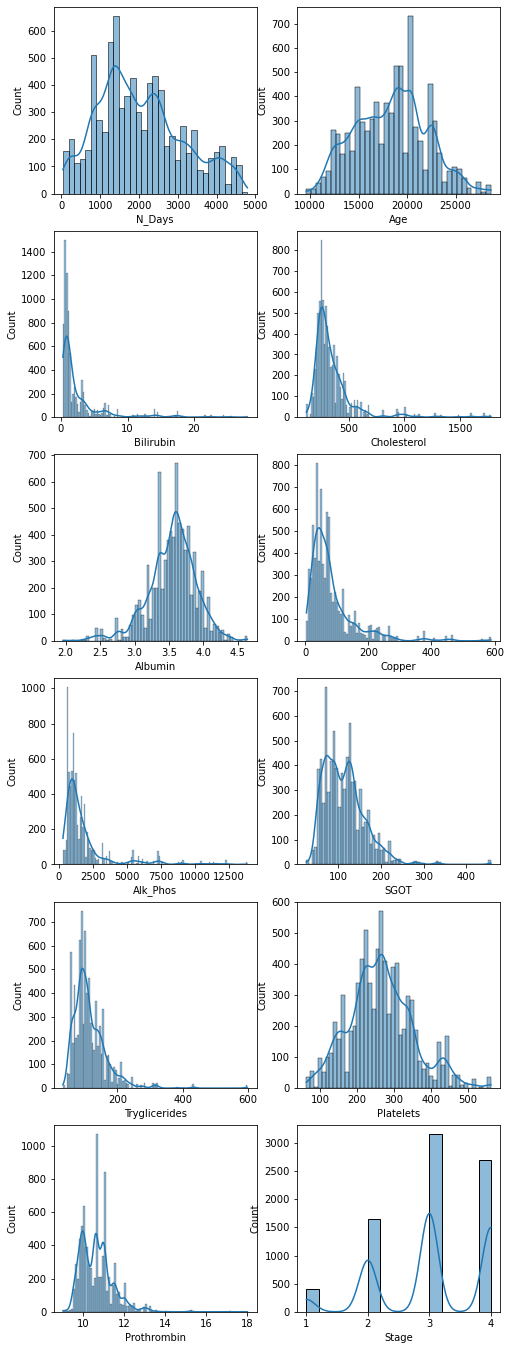

In [12]:
# 数値データをプロットする

# 数値カラムの行数を取得
# ※//にすると小数点切り下げになるみたい
rows = (len(num_train.columns)+1)//2
# ※_はfigsizeで指定した描画領域が返ってくるみたい
# ※axesはそれぞれのグラフデータを表してそう
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(num_train.columns):
    hor = i%2 # 水平の位置
    ver = i//2 # 垂直の位置
    # seabornでヒストグラムを描画
    sns.histplot(data = num_train[col], kde = True, ax = axes[ver, hor])

In [13]:
# カテゴリ特徴を抽出する
# ※astype('category')でカテゴリー型に変換もしている
cat_train = train.select_dtypes(include = ['object']).astype('category')
cat_train.head()

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,D-penicillamine,M,N,N,N,N,D
1,Placebo,F,N,N,N,N,C
2,Placebo,F,N,Y,Y,Y,D
3,Placebo,F,N,N,N,N,C
4,Placebo,F,N,Y,N,N,C


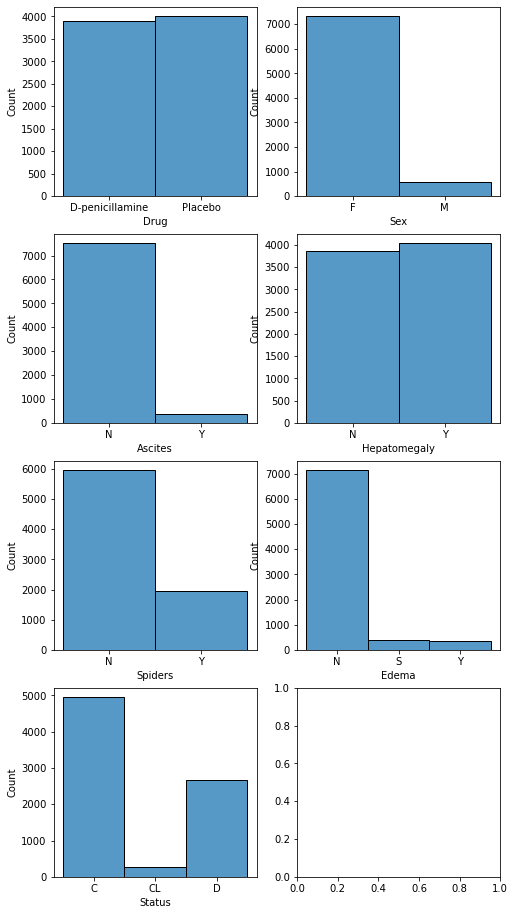

In [14]:
# カテゴリデータをプロットする

# カテゴリーカラムの行数を取得
# ※//にすると小数点切り下げになるみたい
rows = (len(cat_train.columns)+1)//2
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(cat_train.columns):
    hor = i%2
    ver = i//2
    sns.histplot(data = cat_train[col], ax = axes[ver, hor])

基本的な洞察:

    一部のカテゴリ特徴列 (性別) は非常に不均衡であるため、データのバランスをとるためにリサンプリングを検討してください。
    一部の数値特徴には負の歪みまたは正の歪みの症状があるため、次の適用を検討してください。
        データ変換
        外れ値の除去
        データの正規化
        データの次元を削減する
    一部のカテゴリ特徴量は、特徴量エンジニアリングを適用して bool 型として変換できます (例: Y は True、N は False)

# 特徴量エンジニアリング

In [15]:
train_eng = train.copy()
test_eng = test.copy()

In [16]:
# カテゴリ特徴量の特徴量エンジニアリング
def col_transform (df:pd.DataFrame):
    df_trans  = df.copy()
    # 生物項特徴量に手動変換を適用する
    for col in df.select_dtypes(include=['object']):
        # この判定でユニークとなる値の数を見て、3以下かつSex以外かで判定行っている
        if df_trans[col].nunique() < 3 and (col != 'Sex'):
            if col == 'Drug':
                df_trans[col] = df_trans[col].map({'D-penicillamine': True, 'Placebo': False}).astype('bool')
            else:
                df_trans[col] = df_trans[col].map({'Y': True, 'N': False}).astype('bool')
        else:
            # 1 つのホットエンコーディングを他のホットエンコーディングに適用する
            df_trans = pd.concat([df_trans, pd.get_dummies(df_trans[col], prefix = col)], axis = 1)
            df_trans = df_trans.drop(col, axis = 1)
    return df_trans

In [17]:
train_eng1 =col_transform(train_eng)
train_eng1

,N_Days,Drug,Age,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,...,Prothrombin,Stage,Sex_F,Sex_M,Edema_N,Edema_S,Edema_Y,Status_C,Status_CL,Status_D
0,999,True,21532,False,False,False,2.3,316.0,3.35,172.0,...,9.7,3.0,0,1,1,0,0,0,0,1
1,2574,False,19237,False,False,False,0.9,364.0,3.54,63.0,...,11.0,3.0,1,0,1,0,0,1,0,0
2,3428,False,13727,False,True,True,3.3,299.0,3.55,131.0,...,11.7,4.0,1,0,0,0,1,0,0,1
3,2576,False,18460,False,False,False,0.6,256.0,3.50,58.0,...,10.7,3.0,1,0,1,0,0,1,0,0
4,788,False,16658,False,True,False,1.1,346.0,3.65,63.0,...,10.6,4.0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,True,16839,False,False,False,0.8,309.0,3.56,38.0,...,9.9,2.0,1,0,1,0,0,1,0,0
7901,1492,False,17031,False,True,False,0.9,260.0,3.43,62.0,...,10.0,4.0,1,0,1,0,0,1,0,0
7902,1576,True,25873,False,False,True,2.0,225.0,3.19,51.0,...,12.7,2.0,1,0,0,1,0,0,0,1
7903,3584,True,22960,False,True,False,0.7,248.0,2.75,32.0,...,10.6,4.0,0,1,1,0,0,0,0,1


In [18]:
# 正規化された類似分布に PowerTransformer を適用する
from sklearn.preprocessing import PowerTransformer
num_train3 = num_train.copy()

transformer = PowerTransformer(method = 'yeo-johnson')

num_train3 = transformer.fit_transform(num_train3)

num_train3 = pd.DataFrame(num_train3, columns = num_train.columns)
num_train3

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,-0.914653,0.863633,0.717416,0.124061,-0.635276,1.316134,0.420889,1.308370,-1.390037,1.411685,-1.446045,-0.145370
1,0.569410,0.258459,-0.484236,0.503971,-0.095100,0.021285,0.261888,0.604105,-0.443003,1.085364,0.649597,-0.145370
2,1.218335,-1.277713,1.071075,-0.036707,-0.065494,0.966108,-0.300542,0.304625,-2.096879,-0.726509,1.359413,1.197711
3,0.571019,0.049453,-1.045297,-0.528404,-0.212338,-0.085619,0.467241,-0.961579,-0.210362,0.107898,0.271867,-0.145370
4,-1.169380,-0.444194,-0.205571,0.372685,0.237154,0.021285,-0.058706,0.428875,-0.210362,0.428291,0.134120,1.197711
...,...,...,...,...,...,...,...,...,...,...,...,...
7900,-0.727442,-0.394014,-0.648826,0.059799,-0.035768,-0.631987,0.446122,-0.707716,1.782218,0.912761,-1.033486,-1.206382
7901,-0.389296,-0.340935,-0.484236,-0.476493,-0.412969,0.000600,0.261888,0.730725,-0.774893,0.197562,-0.841884,1.197711
7902,-0.306924,1.965313,0.560961,-0.986701,-1.057970,-0.251891,-0.482656,-1.015662,-1.437573,-0.713856,2.073339,-1.206382
7903,1.329829,1.231820,-0.834454,-0.636750,-2.076244,-0.853569,-0.347290,-1.497386,0.319376,-0.453550,0.134120,1.197711


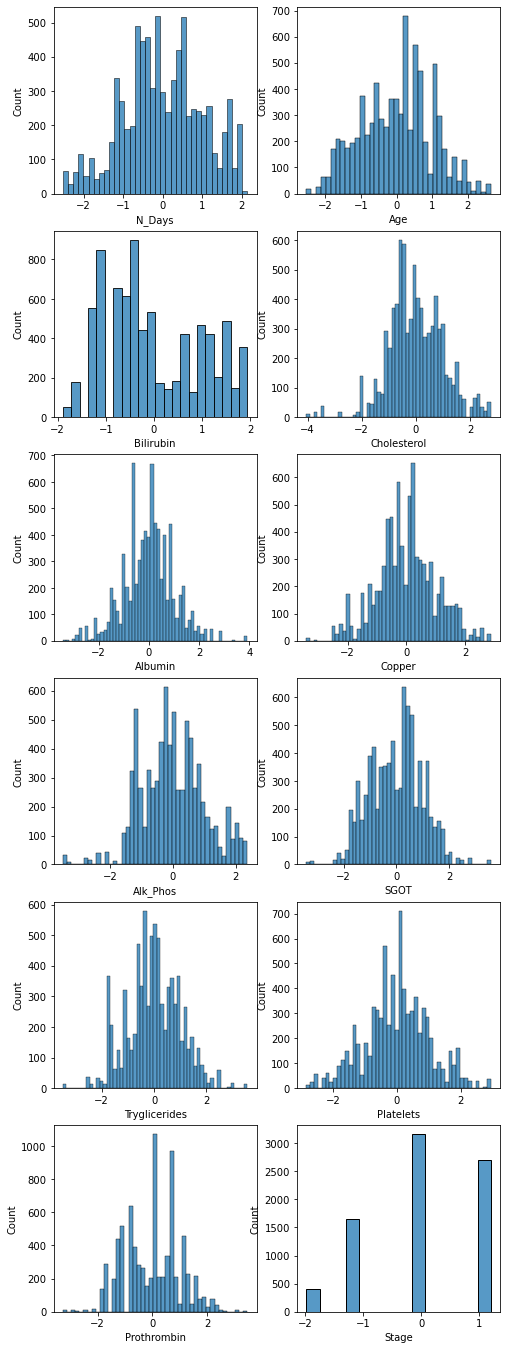

In [19]:
rows = (len(num_train3.columns)+1)//2
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(num_train3.columns):
    hor = i%2
    ver = i//2
    sns.histplot(data = num_train3[col], ax = axes[ver, hor])

In [20]:
train_engineered = pd.concat([num_train3, train_eng1.drop(num_train3.columns, axis = 1)], axis = 1)
train_engineered.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Hepatomegaly,Spiders,Sex_F,Sex_M,Edema_N,Edema_S,Edema_Y,Status_C,Status_CL,Status_D
0,-0.914653,0.863633,0.717416,0.124061,-0.635276,1.316134,0.420889,1.308370,-1.390037,1.411685,...,False,False,0,1,1,0,0,0,0,1
1,0.569410,0.258459,-0.484236,0.503971,-0.095100,0.021285,0.261888,0.604105,-0.443003,1.085364,...,False,False,1,0,1,0,0,1,0,0
2,1.218335,-1.277713,1.071075,-0.036707,-0.065494,0.966108,-0.300542,0.304625,-2.096879,-0.726509,...,True,True,1,0,0,0,1,0,0,1
3,0.571019,0.049453,-1.045297,-0.528404,-0.212338,-0.085619,0.467241,-0.961579,-0.210362,0.107898,...,False,False,1,0,1,0,0,1,0,0
4,-1.169380,-0.444194,-0.205571,0.372685,0.237154,0.021285,-0.058706,0.428875,-0.210362,0.428291,...,True,False,1,0,1,0,0,1,0,0


In [21]:
num_test = test_eng.select_dtypes(include=['int', 'float'])
test_eng1 = col_transform(test_eng)
num_test1 = pd.DataFrame(transformer.transform(num_test), columns = num_test.columns)
test_engineered = pd.concat([num_test1, test_eng1.drop(num_test1.columns, axis = 1)], axis = 1)
test_engineered.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Stage,Drug,Ascites,Hepatomegaly,Spiders,Sex_F,Sex_M,Edema_N,Edema_S,Edema_Y
0,1.508158,0.388355,-0.086678,1.380682,-0.580392,0.061686,0.452329,0.895810,-0.382381,1.755820,...,-1.206382,True,False,True,False,1,0,1,0,0
1,0.483461,-0.917739,-0.205571,1.701809,2.200202,0.538268,0.045511,0.895810,0.974303,-0.380957,...,-1.206382,True,False,False,False,1,0,1,0,0
2,-2.484784,-1.447246,0.560961,-2.744295,-1.615927,-0.385249,-0.426749,-1.015662,-0.077179,-0.551537,...,1.197711,False,False,True,False,1,0,0,0,1
3,0.369415,0.596288,-1.045297,-0.097461,0.879042,-0.565777,-1.613465,0.428875,-1.744806,0.119162,...,-1.206382,True,False,False,False,1,0,1,0,0
4,-0.269252,0.960134,0.119151,-0.271044,-1.592856,0.863856,-0.165520,0.418106,0.481501,-0.453550,...,-1.980148,True,False,True,False,1,0,1,0,0


In [22]:
from sklearn.preprocessing import LabelEncoder
coder = LabelEncoder()
y = coder.fit_transform (train.Status)
X = train_engineered.drop(['Status_C', 'Status_CL', 'Status_D'] ,axis = 1)
y

array([2, 0, 2, ..., 2, 2, 0])

In [23]:
# ベースラインモデルの構築
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
lgbmodel = LGBMClassifier(random_state=42, num_class = 3)

lgbmodel.fit(X, y)

pred = lgbmodel.predict_proba(X)
log_loss(y, pred)

print ("CV score of LGBM is ", abs(cross_val_score(lgbmodel, X, y, cv = 4, scoring='neg_log_loss').mean()))

rfmodel = RandomForestClassifier(criterion = 'log_loss', random_state=42)
print ("CV score of RFmodel is ", abs(cross_val_score(rfmodel, X, y, cv = 4, scoring='neg_log_loss').mean()))
xgbmodel = XGBClassifier(random_state=42)
print ("CV score of xgbmodel is ", abs(cross_val_score(xgbmodel, X, y, cv = 4, scoring='neg_log_loss').mean()))

CV score of LGBM is  0.4710449548083705
CV score of RFmodel is  0.5372527073194291
CV score of xgbmodel is  0.5147691481007647


In [24]:
# LGBM モデルの方が比較的優れているので、Optuna 経由で lgbmodel を調整してみましょう
import optuna
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',50,500),
        "max_depth":trial.suggest_int('max_depth',3,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,100),
        "subsample" : trial.suggest_float('subsample', 0.4, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 64),
    }
    lgbmmodel_optuna = LGBMClassifier(**params, device = 'gpu', random_state=42)
    cv = abs(cross_val_score(lgbmmodel_optuna, X, y, cv = 4,scoring='neg_log_loss').mean())
    return cv

In [25]:
# 最良の値: 0.4341508071086889、スタディをローカルで実行しました
lgb_params = {'n_estimators': 479,
 'max_depth': 25,
 'learning_rate': 0.011780201673685327,
 'reg_alpha': 0.010913316411519302,
 'reg_lambda': 0.024314296610050013,
 'min_child_weight': 3.100349976889409,
 'min_child_samples': 99,
 'subsample': 0.4975668919008305,
 'subsample_freq': 0,
 'colsample_bytree': 0.3960164652068705,
 'num_leaves': 63}

lgb_opt = LGBMClassifier(**lgb_params, random_state=42, 
                         #device = 'gpu'
                        )
lgb_opt.fit(X, y)
preds = lgb_opt.predict_proba(test_engineered)
preds = pd.DataFrame(preds, columns = ['C', 'CL', 'D'])

In [26]:
sub['Status_C'] = preds['C']
sub['Status_CL'] = preds['CL']
sub['Status_D'] = preds['D']

sub.to_csv('submission.csv', index = False)
sub

,id,Status_C,Status_CL,Status_D
0,7905,0.526261,0.031336,0.442403
1,7906,0.590450,0.275634,0.133917
2,7907,0.032265,0.012175,0.955560
3,7908,0.969945,0.003653,0.026402
4,7909,0.851401,0.036450,0.112149
...,...,...,...,...
5266,13171,0.877051,0.060987,0.061962
5267,13172,0.972123,0.002851,0.025025
5268,13173,0.892324,0.009551,0.098126
5269,13174,0.987603,0.004593,0.007804


# CB モデルと XGB モデルによるアンサンブル

In [27]:
## Optuna tunning for XGB
from xgboost import XGBClassifier
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 300,750),
    'max_depth': trial.suggest_int('max_depth', 3, 50),
    'min_child_weight': trial.suggest_float('min_child_weight', 2,50),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log = True),
    'subsample': trial.suggest_float('subsample', 0.2, 1),
    'gamma': trial.suggest_float('gamma', 1e-4, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree',0.2,1),
    'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.2,1),
    'colsample_bynode': trial.suggest_float('colsample_bynode', 0.2, 1)
    }
    xgbmodel_optuna = XGBClassifier(**params, random_state = 42, tree_method = 'gpu_hist')

    cv = abs(cross_val_score(xgbmodel_optuna, X, y, cv = 4,scoring='neg_log_loss').mean())
    return cv

In [28]:
from catboost import CatBoostClassifier

def objective(trial):
    params = {
    'iterations': trial.suggest_int('iterations', 100,600),
    'depth': trial.suggest_int('depth', 3, 50),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2,50),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log = True),
    'subsample': trial.suggest_float('subsample', 0.2, 1),
    #'rsm': trial.suggest_float('rsm',0.2,1),
    'random_strength':trial.suggest_float('random_strength', 5e-3, 0.3)
    
    }
    cb_optuna = CatBoostClassifier(**params, random_state = 42, 
                                   grow_policy = 'Lossguide', 
                                   task_type = 'GPU',
                                   bootstrap_type = 'Poisson',
                                   #allow_writing_files=False
                                  )

    cv = abs(cross_val_score(cb_optuna, X, y, cv = 4,scoring='neg_log_loss').mean())
    return cv

In [29]:
# 最良の値: 0.4341508071086889、スタディをローカルで実行しました
lgb_params = {'n_estimators': 479,
 'max_depth': 25,
 'learning_rate': 0.011780201673685327,
 'reg_alpha': 0.010913316411519302,
 'reg_lambda': 0.024314296610050013,
 'min_child_weight': 3.100349976889409,
 'min_child_samples': 99,
 'subsample': 0.4975668919008305,
 'subsample_freq': 0,
 'colsample_bytree': 0.3960164652068705,
 'num_leaves': 63}

lgb_opt = LGBMClassifier(**lgb_params, random_state=42, 
                         #device = 'gpu'
                        )

# 最適な値: 0.4287233556800304
xgb_params = {'n_estimators': 397,
 'max_depth': 44,
 'min_child_weight': 4.8419409783368215,
 'learning_rate': 0.049792103525168455,
 'subsample': 0.7847543051746505,
 'gamma': 0.4377096783729759,
 'colsample_bytree': 0.22414960640035653,
 'colsample_bylevel': 0.8173336142032213,
 'colsample_bynode': 0.9468109886478254}

xgb_opt = XGBClassifier(**xgb_params, 
                        random_state=42, 
                        #tree_method = 'gpu_hist'
                       )

# 最適な値: 0.4449797087690473
CB_params = {
 'iterations': 593,
 'depth': 43,
 'min_data_in_leaf': 42,
 'learning_rate': 0.023456006693305914,
 'subsample': 0.8018560299887264,
 'random_strength': 0.04176274518438195,
 'grow_policy': 'Lossguide',
 'bootstrap_type' : 'Bernoulli'
     #'task_type': 'GPU',
 #'bootstrap_type': 'Poisson'
  
}

CB_opt = CatBoostClassifier(**CB_params, 
                            random_state=42, 
                           )

In [ ]:
Ensemble = VotingClassifier(estimators = [('lgb', lgb_opt), ('xgb', xgb_opt), ('CB', CB_opt)], 
                            voting='soft',
                            weights = [0.4,0.6,0.0]   #Adjust weighting since XGB performs better in local environment
                            )
Ensemble.fit(X, y)
preds = Ensemble.predict_proba(test_engineered)
preds = pd.DataFrame(preds, columns = ['C', 'CL', 'D'])

In [31]:
sub['Status_C'] = preds['C']
sub['Status_CL'] = preds['CL']
sub['Status_D'] = preds['D']

sub.to_csv('submission2.csv', index = False)
sub

,id,Status_C,Status_CL,Status_D
0,7905,0.385320,0.026384,0.588296
1,7906,0.551944,0.238144,0.209912
2,7907,0.022423,0.008923,0.968653
3,7908,0.975806,0.003828,0.020366
4,7909,0.877715,0.047625,0.074660
...,...,...,...,...
5266,13171,0.879544,0.072358,0.048098
5267,13172,0.977464,0.003080,0.019456
5268,13173,0.929416,0.011259,0.059324
5269,13174,0.988645,0.004775,0.006581
